# Importando Bibliotecas

In [1]:
!pip install spacy nltk --quiet
!python -m spacy download pt_core_news_lg --quiet

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [ ]:
import os
import zipfile
import glob
import pandas as pd
import spacy

/home/gustavo-lelli/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando e limpando os dados

In [3]:
def extracting_dataset():
	# Encontrando o arquivo .zip
	zip_file = glob.glob("*.zip")
	zip_file = zip_file[0]

	# Checa se o arquivo zip existe
	if os.path.exists(os.path.basename(zip_file)):
		try:
			with zipfile.ZipFile(zip_file, 'r') as zip_ref:
				zip_ref.extractall()
				print(f"Extração bem-sucedida {zip_file}")
		except zipfile.BadZipFile:
			print(f"Erro: {zip_file} não é um arquivo zip.")
		except Exception as e:
			print(f"Ocorreu um erro durante a extração {zip_file}: {e}")
	else:
		print(f"Warning: {zip_file} não encontrado.")
   
	df = pd.read_csv(zip_file.replace(".zip", "")) 

	# Remove os valores NaN
	df.dropna(inplace=True)

	# Resetando o índice
	df.drop(columns=['original_index'], inplace=True)
	df.reset_index(drop=True, inplace=True)
	# print(df)

	# Criando uma nova coluna com os valores de sentimento
	df['sentiment'] = df['rating'].apply(lambda x: 'negative' if x in [1, 2] else 'positive' if x in [4, 5] else 'neutral')
	df.head(10) 

	return df

dataset = extracting_dataset()

Extração bem-sucedida b2w.csv.zip


In [4]:
dataset.head()

,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating,sentiment
0,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1.0,4,1,1,positive
1,Produto excepcional! recomendo!!! inovador e ...,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1.0,5,1,1,positive
2,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0.0,1,1,1,negative
3,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1.0,5,1,1,positive
4,"ótmo produto atendeu as expectativas, a entreg...","otmo produto atendeu as expectativas, a entreg...","['otmo', 'produto', 'atendeu', 'as', 'expectat...",1.0,4,1,1,positive


# Análise Semântica

In [5]:
def analisar_polaridade(texto):
	import requests
	url = "https://raw.githubusercontent.com/marlovss/OpLexicon/refs/heads/main/OpLexicon.csv"
	response = requests.get(url)
	palavras_positivas = set()
	palavras_negativas = set()

	for line in response.text.split('\n'):
		if line.startswith('#'): continue
		keys = line.split(',')
		if len(keys) < 2: continue
		word = keys[0]
		pol = keys[2]
		if pol == '1': palavras_positivas.add(word)
		elif pol == '-1': palavras_negativas.add(word)
	
	nlp = spacy.load("pt_core_news_lg")
	doc = nlp(texto)
	score = 0

	import matplotlib.pyplot as plt

	# Plot das normas dos vetores
	words = [token.text for token in doc]
	norms = [token.vector_norm for token in doc]

	plt.figure(figsize=(10,5))
	plt.bar(words, norms)
	plt.title("Magnitude dos Embeddings (spaCy)")
	plt.ylabel("Norma L2")
	plt.xticks(rotation=45)
	plt.show()
	
	for token in doc:
		# Verificar palavras-chave
		if token.lemma_ in palavras_positivas:
			score += token.vector_norm * 0.5
		elif token.lemma_ in palavras_negativas:
			score -= token.vector_norm * 0.5
		
		# Análise de dependência
		if token.dep_ == "neg":
			score *= -1  # Inverte polaridade
	
	return ["positivo" if score > 2 else "negativo" if score < -2 else "neutro", score]

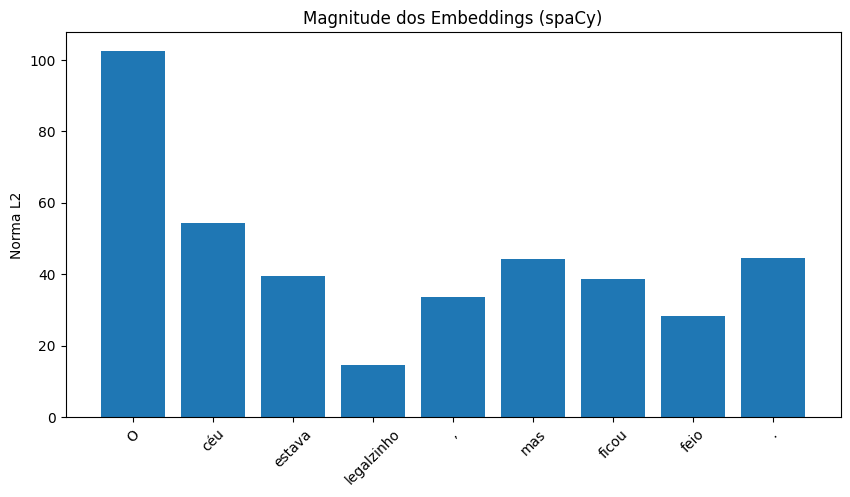

Texto: O céu estava legalzinho, mas ficou feio.
Resultado: negativo (Score: -14.131437301635742)


In [18]:
# Testando a função
texto_teste = "O céu estava legalzinho, mas ficou feio."
resultado, score = analisar_polaridade(texto_teste)
print(f"Texto: {texto_teste}\nResultado: {resultado} (Score: {score})")